In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


import numpy as np
import sys
sys.path.append('../VideoPose3D/')
from custom_run import *
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import collections  as mc
import numpy as np
import cv2


Bad key savefig.frameon in file /home/david/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/david/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/david/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an upd

In [2]:
model = get_model('../VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin')

In [8]:
# path_to_dataset = '../VideoPose3D/data/data_2d_custom_federer.npz'
openpose_dataset = '../VideoPose3D/data_federer_openpose_interpolated.npz'
detectron_dataset =  '../VideoPose3D/data_test_federer.npz'


In [4]:
joints_openpose = predict_from_dataset(model, openpose_dataset)
joints_detectron = predict_from_dataset(model, detectron_dataset)

In [5]:
joints = joints_detectron

In [10]:
from lib.vizualisation import PoseViewer
from lib.pose import Pose

<IPython.core.display.Javascript object>


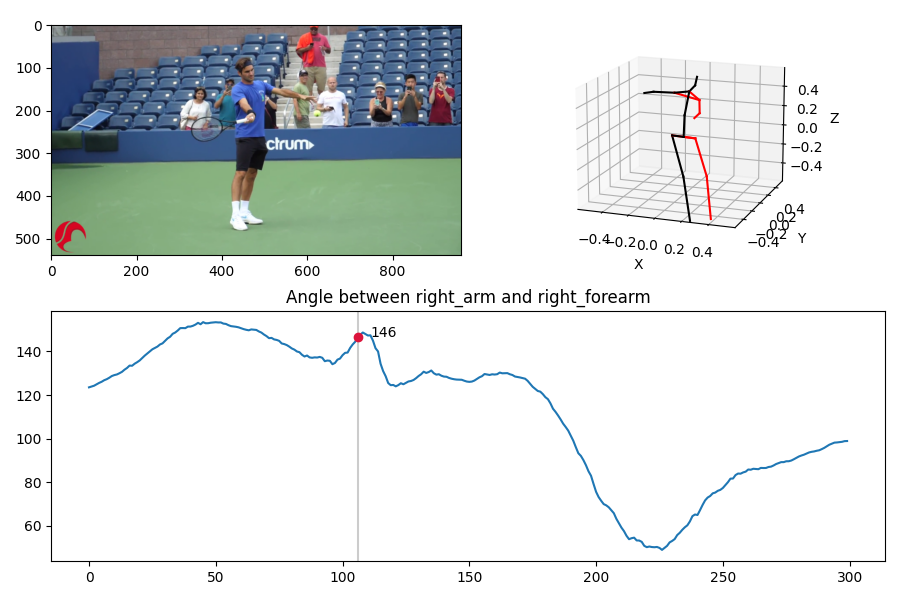

interactive(children=(IntSlider(value=0, description='x', max=299), Output()), _dom_classes=('widget-interact'…

In [13]:
poses = [Pose(joints_in_frame) for joints_in_frame in joints]
pose_viewer = PoseViewer(poses, 'federer_cut.mp4')
pose_viewer.plot_pose_evolution(('right_arm', 'right_forearm'))

In [6]:
angles_openpose, vec1, vec2 = angle_evolution(joints_openpose, ('right_elbow', 'right_wrist'), ('right_elbow', 'right_shoulder'))
angles_detectron, vec1, vec2 = angle_evolution(joints_detectron, ('right_elbow', 'right_wrist'), ('right_elbow', 'right_shoulder'))


NameError: name 'angle_evolution' is not defined

In [ ]:
plt.plot(np.arange(300), angles_openpose)
plt.plot(np.arange(300), angles_detectron)

In [7]:
body_parts = {
    'nose': 9,
    'top_head': 10,
    'left_shoulder': 11,
    'right_shoulder': 14,
    'left_elbow': 12,
    'right_elbow': 15,
    'left_wrist': 13,
    'right_wrist': 16,
    'left_hip': 4,
    'right_hip': 1,
    'middle_hip':0,
    'middle_body': 7,
    'left_knee': 5,
    'right_knee': 2,
    'neck': 8,
    'left_ankle':6,
    'right_ankle':3
}

def segment(joints, part1, part2):
    idx1 = body_parts[part1]
    idx2 = body_parts[part2]
    
    start = joints[idx1]
    end = joints[idx2]
    
    return np.array([start[0], end[0]]), np.array([start[1], end[1]]), np.array([start[2], end[2]])

def vector(point1, point2):
    vec = point2-point1
    return (vec[0], vec[1], vec[2])

def point_of_part(joints, part):
    return joints[body_parts[part]]

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/np.pi

def angle_evolution(joints, parts1, parts2):
    angles = []
    for joints_in_frame in joints:
        vec1 = vector(point_of_part(joints_in_frame, parts1[0]), point_of_part(joints_in_frame, parts1[1]))
        vec2 = vector(point_of_part(joints_in_frame, parts2[0]), point_of_part(joints_in_frame, parts2[1]))
        angle = angle_between(vec1, vec2)
        angles.append(angle)
    return angles, vec1, vec2    

In [8]:
segments_to_plot = [
 ('right_wrist', 'right_elbow'), ('right_elbow', 'right_shoulder'), ('right_shoulder', 'neck'),
 ('left_knee', 'left_hip'), ('right_knee', 'right_hip'), ('left_hip', 'middle_hip'), 
 ('right_hip', 'middle_hip'), ('left_wrist', 'left_elbow'), ('left_elbow', 'left_shoulder'),
 ('middle_hip', 'middle_body'), ('middle_body', 'neck'), ('left_shoulder', 'neck'),
 ('top_head', 'nose'), ('nose', 'neck'), ('left_ankle', 'left_knee'), ('right_ankle', 'right_knee')
]

In [9]:
cap = cv2.VideoCapture('federer_cut.mp4')

frames = []

while True:  
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (960, 540))  
    frames.append(frame)
    
frames = np.stack(frames)

cap.release()

# Combine both interactive plots

In [10]:
def init_pose_plot(ax):
    radius = 1.7

    ax.set_xlim3d([-radius/3, radius/3])
    ax.set_zlim3d([-radius/3, radius/3])
    ax.set_ylim3d([-radius/3, radius/3])
    
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_axis_off()
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])
    
        
    ax.dist = 7.5

    ax.set_zlabel('Z')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.view_init(elev=15., azim=-70)

    joints_in_frame = joints[0]

    lines_3d = []

    for (part1, part2) in segments_to_plot:
        c = 'red' if 'right' in part1 or 'right' in part2 else 'black'
        _x, _y, _z = segment(joints_in_frame, part1, part2)
        line_3d = ax.plot(_x, _y, _z, zdir='z', c=c)[0]
        lines_3d.append(line_3d)
        
    return lines_3d    

In [11]:
angles, vec1, vec2 = angle_evolution(joints, ('right_elbow', 'right_wrist'), ('right_elbow', 'right_shoulder'))
angles, vec1, vec2 = angle_evolution(joints, ('right_shoulder', 'right_elbow'), ('right_shoulder', 'left_shoulder'))


In [62]:
angles_arm = []

for i in range(300):
    vec1 = vector(point_of_part(joints[i], 'right_shoulder'), point_of_part(joints[i], 'right_elbow'))
    angles_arm.append(angle_between(vec1, (0, 1, 0)))

In [66]:
plt.plot(angles_arm)
plt.show()

<IPython.core.display.Javascript object>


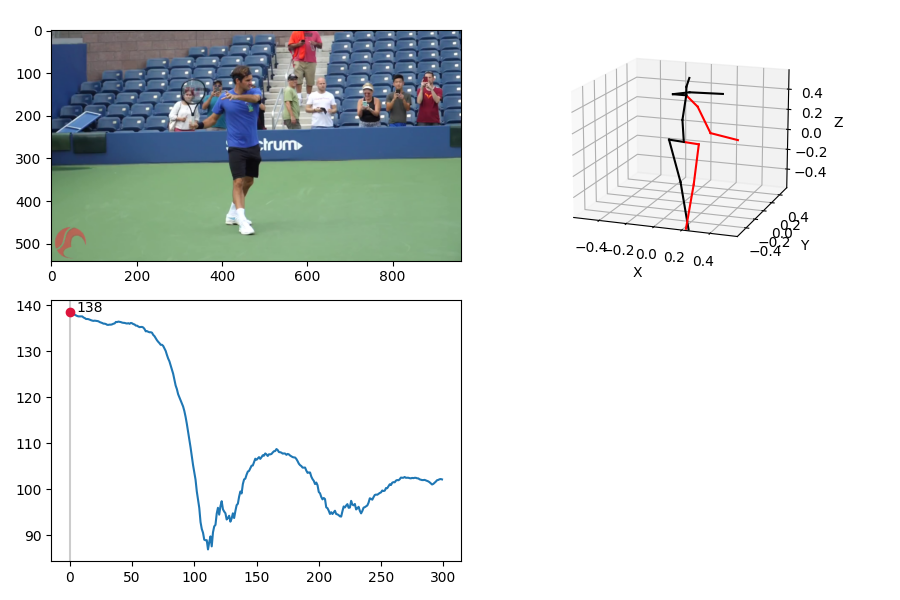

interactive(children=(IntSlider(value=0, description='x', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.update(x)>

In [12]:
fig = plt.figure(figsize=(9,6))

# init frame plot
ax_frame = fig.add_subplot(2, 2, 1)
im = ax_frame.imshow(frames[0])

# init pose plot
ax_pose = fig.add_subplot(2, 2, 2, projection='3d')
lines_3d = init_pose_plot(ax_pose)

# init pose plot
ax_angle = fig.add_subplot(2, 2, 3)
ax_angle.plot(angles)

# init angle plot
vertical_line = ax_angle.axvline(color='k', alpha=0.2)
point, = ax_angle.plot([0],[angles[0]], marker="o", color="crimson", zorder=3)
txt = ax_angle.text(5, angles[0], int(angles[0]))

fig.tight_layout()
fig.show()

def update_frame_plot(im, idx):
    im.set_data(frames[idx])
    
def update_pose_plot(lines_3d, idx):    
    for i, (part1, part2) in enumerate(segments_to_plot):
        _x, _y, _z = segment(joints[idx], part1, part2)
        lines_3d[i].set_ydata(_y)
        lines_3d[i].set_xdata(_x)
        lines_3d[i].set_3d_properties(_z, zdir='z')
        
def update(x):
    update_frame_plot(im, x)
    update_pose_plot(lines_3d, x)
    
    point.set_xdata([x])
    point.set_ydata(angles[x])
    vertical_line.set_xdata([x])
    txt.set_position((x + 5, angles[x]))
    txt.set_text(int(angles[x]))

    
    fig.canvas.draw()

interact(update, x=widgets.IntSlider(min=0, max=299, step=1, value=0))

In [13]:
import matplotlib.gridspec as gridspec

<IPython.core.display.Javascript object>


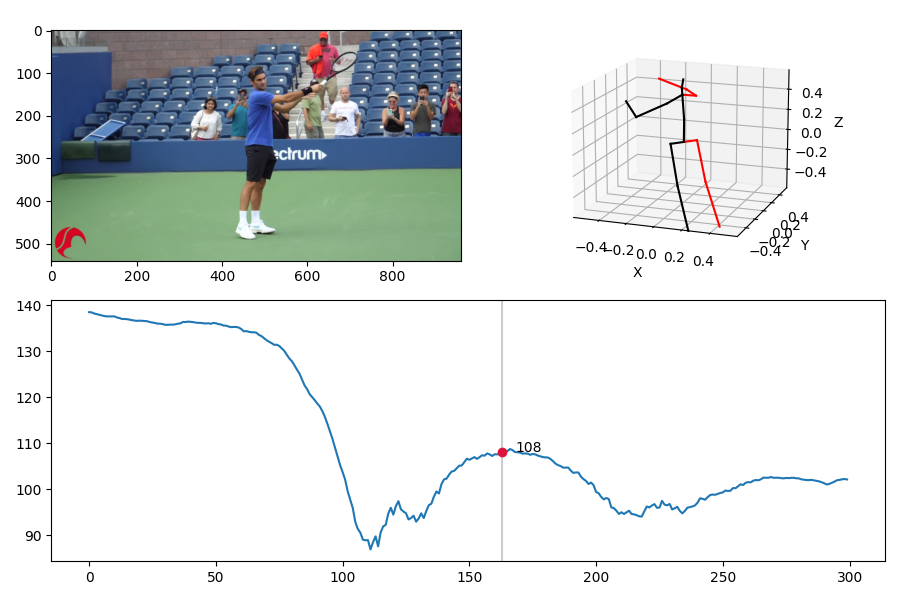

interactive(children=(IntSlider(value=0, description='x', max=299), Output()), _dom_classes=('widget-interact'…

<function __main__.update(x)>

In [14]:
fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(2, 2)

# init frame plot
ax_frame = plt.subplot(gs[0, 0])
im = ax_frame.imshow(frames[0])

# init pose plot
ax_pose = plt.subplot(gs[0, 1], projection='3d')
lines_3d = init_pose_plot(ax_pose)

# init pose plot
ax_angle = plt.subplot(gs[1, :])
ax_angle.plot(angles)

# init angle plot
vertical_line = ax_angle.axvline(color='k', alpha=0.2)
point, = ax_angle.plot([0],[angles[0]], marker="o", color="crimson", zorder=3)
txt = ax_angle.text(5, angles[0], int(angles[0]))

fig.tight_layout()
fig.show()

def update_frame_plot(im, idx):
    im.set_data(frames[idx])
    
def update_pose_plot(lines_3d, idx):    
    for i, (part1, part2) in enumerate(segments_to_plot):
        _x, _y, _z = segment(joints[idx], part1, part2)
        lines_3d[i].set_ydata(_y)
        lines_3d[i].set_xdata(_x)
        lines_3d[i].set_3d_properties(_z, zdir='z')
        
def update(x):
    update_frame_plot(im, x)
    update_pose_plot(lines_3d, x)
    
    point.set_xdata([x])
    point.set_ydata(angles[x])
    vertical_line.set_xdata([x])
    txt.set_position((x + 5, angles[x]))
    txt.set_text(int(angles[x]))

    
    fig.canvas.draw()

interact(update, x=widgets.IntSlider(min=0, max=299, step=1, value=0))